In [14]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy 
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

# Necessary imports

import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear
 
from qiskit import QuantumCircuit
#from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
import pylatexenc

from qiskit.circuit.library import ZZFeatureMap, EfficientSU2

import pandas as pd

torch.backends.cudnn.benchmark = True


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

directory = 'Experiments/'
experiment_id = 'Initial/'

num_qubits = 3
num_layers = 1


cpu


QNN Training Parameters: 6
QNN Input Parameters: 3
QNN Circuit Depth: 2


/var/folders/ks/75nc1bbj5y927lr6v6qstz540000gn/T/ipykernel_53481/92211675.py:10: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


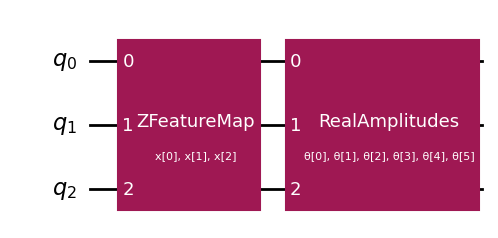

In [16]:
def create_qnn():
    qc = QuantumCircuit(num_qubits)
    feature_map = ZFeatureMap(num_qubits)
    ansatz = RealAmplitudes(num_qubits=num_qubits, reps=num_layers)

    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    
    return qnn

qnn = create_qnn()

print("QNN Training Parameters:", qnn.num_weights) 
print("QNN Input Parameters:", qnn.num_inputs)
print("QNN Circuit Depth:", qnn.circuit.depth())

qnn.circuit.draw('mpl')

In [17]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.qnn = nn.Sequential(nn.LazyLinear(qnn.num_inputs),
            nn.LazyLinear(qnn.num_inputs),
            nn.Tanh(),
            TorchConnector(qnn),
            nn.LazyLinear(1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.qnn(x)
        return x

In [18]:
net = Model().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()
batch_size = 32
num_epochs = 1000

net.to(device)
net.train()

Model(
  (qnn): Sequential(
    (0): LazyLinear(in_features=0, out_features=3, bias=True)
    (1): LazyLinear(in_features=0, out_features=3, bias=True)
    (2): Tanh()
    (3): TorchConnector()
    (4): LazyLinear(in_features=0, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [19]:
# Load data

import pandas as pd

df = pd.read_csv("Games.csv")

df.fillna(-1, inplace=True)

unique_years = df["YEAR"].unique()
test_years = random.sample(list(unique_years), k=2)

test_df = df[df["YEAR"].isin(test_years)]
train_val_df = df[~df["YEAR"].isin(test_years)]

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

features = ["SEED1", "SEED2", "DUNKS FG%1", "DUNKS FG%2", "CURRENT ROUND"]
target = "WINNER"


In [20]:
from torch.utils.data import TensorDataset, DataLoader

def to_tensor(df):
    X = torch.tensor(df[features].values, dtype=torch.float32)
    y = torch.tensor(df[target].values, dtype=torch.float32).unsqueeze(1)
    return TensorDataset(X, y)

In [21]:
train_dataset = to_tensor(train_df)
val_dataset = to_tensor(val_df)
test_dataset = to_tensor(test_df)


In [22]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [23]:
def plot_loss(train, val):
    plt.plot(train, label='Train')
    plt.plot(val, label='Validation')
    plt.legend()
    plt.xlim(0, num_epochs)
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.savefig(directory + experiment_id+  'loss.png')
    plt.show()
    
def plot_accuracy(train, val):
    plt.plot(train, label='Train')
    plt.plot(val, label='Validation')
    plt.xlim(0, num_epochs)
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig(directory + experiment_id+ 'accuracy.png')
    plt.show()
 

In [24]:
def calc_val_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            predicted = (outputs > 0.5).float()

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    return correct / total

def calc_val_loss(loader):
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    return val_loss / len(loader)



In [ ]:
# Initialize lists to store losses and accuracies
losses = []
val_losses = []

best_loss = float('inf')
best_accuracy = 0.0

loss_epoch = 0
accuracy_epoch = 0

train_accuracys = []
val_accuracys = []

# Training loop
for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for X_batch, y_batch in train_loader:
    
        # Move data to device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        preds = net(X_batch)

        if preds.shape != y_batch.shape:
            y_batch = y_batch.view(preds.shape)
      
        # Calculate loss
        loss = criterion(preds, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted = (preds > 0.5).float()
        correct = (predicted == y_batch).sum().item()
        total = y_batch.size(0)
        accuracy = correct / total
        
        epoch_accuracy += accuracy
        epoch_loss += loss.item()
  
    val_loss = calc_val_loss(val_loader)
    val_accuracy = calc_val_accuracy(val_loader)

    losses.append(epoch_loss / len(train_loader))
    train_accuracys.append(epoch_accuracy / len(train_loader))

    val_accuracys.append(val_accuracy)
    val_losses.append(val_loss)
        
    clear_output(wait=True)
    print(f"Epoch [{epoch}/{num_epochs}]\n")
    print(f"TrainnLoss: {epoch_loss / len(train_loader):.4f}")
    print(f"Validation Loss: {val_loss:.4f}\n")
    print(f"Train Accuracy: {epoch_accuracy / len(train_loader):.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f} \n")

    

    if val_loss < best_loss and epoch > 50:
        best_loss = epoch_loss
        loss_epoch = epoch
        torch.save(net.state_dict(), directory + experiment_id + 'best_lost_model.pth')
        
    if val_accuracy > best_accuracy and epoch > 50:
        best_accuracy = val_accuracy
        accuracy_epoch = epoch
        torch.save(net.state_dict(), directory + experiment_id + 'best_accuracy_model.pth')
    
    if epoch % 50 == 0:
        plot_loss(losses, val_losses)
        plot_accuracy(train_accuracys, val_accuracys)
        print(f"Model saved at epoch {epoch} with loss {best_loss:.4f}")
        print(f"Model saved at epoch {epoch} with accuracy {best_accuracy:.4f}")


torch.save(net.state_dict(), directory + experiment_id + 'final_model.pth')
        

Epoch [75/1000]

TrainnLoss: 0.6650
Validation Loss: 0.6550

Train Accuracy: 0.6094
Validation Accuracy: 0.6328 

Model saved at epoch 75 with loss 14.6298


In [ ]:
# Load the best model
best_model = Model().to(device)
best_model.load_state_dict(torch.load(directory + experiment_id + 'best_accuracy_model.pth'))
best_model.eval()

for year in test_years:
    print(year)
    test_year_df = test_df[test_df["YEAR"] == year]
    test_year_df = test_year_df[features]
    
    test_dataset = to_tensor(test_year_df)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

   